In [166]:
import numpy as np
import matplotlib.pyplot as plt
from nn.layers.transformer import Transformer
from nn.losses.classification import CategoricalCrossentropy
from nn.optimizers.first_order import Adam

with open("../data/resources/saved_datasets/tiny_shakespeare.txt", "r") as f:
    o = f.read().splitlines()

datastr = " ".join(o).lower()#[:100]
split = int(0.8 * len(datastr))
train = datastr[:split]
val   = datastr[split:]
vocab = sorted(list(set(datastr)))

def sample_data(example_len, data):
    start_idx = np.random.randint(len(data)-example_len)
    example = data[start_idx:start_idx+example_len]
    return np.array([vocab.index(c) for c in example])

def generate_batch(batch_size, block_size, data):
    data = np.array([sample_data(block_size+1, data) for _ in range(batch_size)])
    decoder_inputs = data[:, :-1]
    targets        = data[:, 1:]
    encoder_inputs = np.ones_like(decoder_inputs)
    return encoder_inputs, decoder_inputs, targets

block_size = 16 # sequence length
batch_size = 128 # batch size
d_model = 32 # dimesion of embedding
d_hidden = 4 # attention dimension
d_ff = 64 # FF projection dimension
n_heads = 8 # number of attention heads
n_layers = 2 # number of encoder and decoder layers
vocab_size = len(vocab)
np.random.seed(1337)

model = Transformer(vocab_size, n_layers, n_heads, d_model, d_hidden, d_ff)
loss  = CategoricalCrossentropy()
optim = Adam(model.parameters(), 1e-3, 0.9, 0.999)

print(model.n_params())

44902


In [165]:
np.random.seed(1337)

steps = 10000
log_step = 10
history = {"train": [], "val": []}
for s in range(steps):
    optim.zero_grad()

    x_enc, x_dec, y = generate_batch(batch_size, block_size, train)
    y_pred = model([x_enc, x_dec])
    l = loss.calculate(y, y_pred)
    history["train"].append(l)

    model.backward(loss.backward())
    optim.step()

    if s % log_step == 0:
        x_enc, x_dec, y = generate_batch(batch_size*10, block_size, val)
        y_pred = model([x_enc, x_dec])
        l = loss.calculate(y, y_pred)
        history["val"] += log_step * [l]
        print(f"step: {s}, train loss: {np.mean(history['train'][-log_step:]):.3f}, val loss: {l:.3f}")

print(f"min loss: {min(history['train'])}")

step: 0, train loss: 8.360, val loss: 8.176
step: 10, train loss: 7.821, val loss: 7.362
step: 20, train loss: 7.113, val loss: 6.847
step: 30, train loss: 6.570, val loss: 6.276
step: 40, train loss: 6.059, val loss: 5.739
step: 50, train loss: 5.544, val loss: 5.230
step: 60, train loss: 5.045, val loss: 4.782
step: 70, train loss: 4.655, val loss: 4.428
step: 80, train loss: 4.305, val loss: 4.172
step: 90, train loss: 4.135, val loss: 4.090
step: 100, train loss: 4.054, val loss: 3.985
step: 110, train loss: 3.941, val loss: 3.889
step: 120, train loss: 3.905, val loss: 3.839
step: 130, train loss: 3.811, val loss: 3.796
step: 140, train loss: 3.776, val loss: 3.740
step: 150, train loss: 3.714, val loss: 3.677
step: 160, train loss: 3.687, val loss: 3.639
step: 170, train loss: 3.657, val loss: 3.612
step: 180, train loss: 3.607, val loss: 3.574
step: 190, train loss: 3.588, val loss: 3.542
step: 200, train loss: 3.565, val loss: 3.523
step: 210, train loss: 3.526, val loss: 3.488

KeyboardInterrupt: 

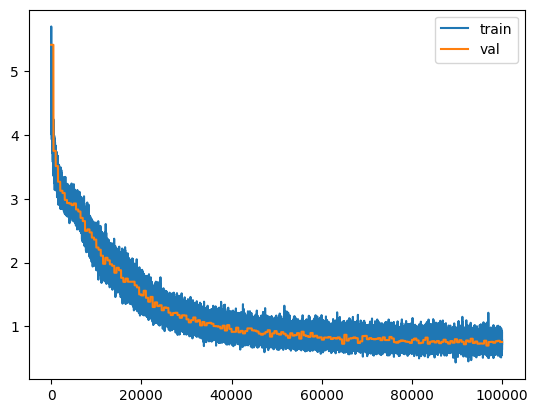

In [135]:
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.legend()

In [150]:
x_enc, x_dec, y = generate_batch(batch_size*10, block_size, val)
y_pred = model([x_enc[0], x_dec[0]])
print("input:", [vocab[i] for i in x_dec[0]])
print("pred:", [vocab[i] for i in y_pred.argmax(axis=-1)])

input: ['b', 'i', 'a', 'n']
pred: ['i', 'a', 'n', 'e']


In [156]:
def generate_tokens(x_seed, out_len):
    x_enc, x_dec = x_seed
    for _ in range(out_len):
        y_pred = model([x_enc, x_dec]).argmax(axis=-1)[-1]
        x_enc[..., :-1] = x_enc[..., 1:]
        x_enc[..., -1] = y_pred
        yield vocab[y_pred]

x_enc, x_dec, _ = generate_batch(1, 4, datastr)

print("".join([vocab[i] for i in x_dec[0]]))
print("".join([t for t in generate_tokens([x_enc[0], x_dec[0]], 100)]))

slai
 ,n,ff,h'h,nnh,fnh,,fn,foh,,nh,fnh,,fn,foh,,nh,fnh,,fn,foh,,nh,fnh,,fn,foh,,nh,fnh,,fn,foh,,nh,fnh,,
